This is Part 1 of my AST 390 Final Porject. In this part, I use REBOUND to solve a 3-body system, where I aim to test if two Jupiter-Massed protoplanets will collide given semi-major axis and eccentricity parameters. I also implement a function that determines when (in years) and what true anomaly said collision occurs.

In [420]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from scipy import signal

We define a close encounter to be that in which either protoplanet is within the Hill sphere radius of the other. The Hill sphere radius is defined as:
$$r_{H} \approx a(1-e) \sqrt[3]{\frac{m_{p}}{3M_{*}}}$$
where $m_{p}$ is the protoplanetary mass, and $M_{*}$ is the central star mass.

For the circular restricted three-body problem, the equation of motion we can derive is:
$$C_{J} = 2U - v^{2}$$
where $C_{J}$ is the Jacobi constant. Using the Jacobi constant we can define zero-velocity surfaces where the particle can never cross. As such, a protoplanet's orbit is guaranteed to be stable (where stability is defined to never have a close encounter) if its Jacobi constant is such that a zero-velocity surface lies between between it and the other protoplanet. This can be written in terms of a minimum orbital separation, expressed with the parameter $\Delta$.
$$a_{2} = a_{1}(1 + \Delta)$$
Orbital Separation, $\Delta$, can be Taylor expanded given $q_{1}$ and $q_{2}$ << 1:
$$\Delta > 2.4(q_{1} + q_{2})^{1/3}$$
The stability of the circular restricted 3-Body problem can be determined by the dimensionless quantity:
$$\Delta _{c} > \sqrt{\frac{8}{3}(e_{1}^2 + e_{2}^2) + 9q^{2/3}}$$


In [421]:
smass = 1.0 #in Solar Mass units
jmass = 0.000954588 #Jupiter Mass in Solar Mass units
e = Symbol('e')
e = solve(2.40*(2.0*jmass)**(1./3.) - (((8./3.)*(e**2 + e**2) + 9*(jmass)**(2./3.)))**(1./2.), e)
if len(e) == 2:
    e = e[1]
    print(f"Eccentricity: {e}")
else:
    e = e[0]
    print(f"Eccentricity: {e}")

Eccentricity: 0.0161470323464714


In [460]:
'''Set-Up Initial Conditions'''
def setupSimulation():
    sim = rebound.Simulation()
    sim.integrator = 'ias15'
    sim.units = ('yr','au','solarmass')
    hill_radius = 1.0*(1-e)*(jmass / (3.0 * smass))**(1.0/3.0)
    sim.add(m = smass)
    sim.add(m = jmass, a= 1.0, e = e, r = hill_radius)
    sim.add(m = jmass, a= 1.0 + (((8./3.)*(e**2 + e**2) + 9*(jmass)**(2./3.)))**(1./2.), e= e,  r = hill_radius, omega = np.pi)
    sim.move_to_com()
    return sim

3 particles in the simulation at t = 0.0 yr
Protoplanet 1 Semi-Major Axis: 1.0000000000000002 AU
Protoplanet 2 Semi-Major Axis: 1.2977327191589918 AU
Period of Protoplanet 1: 0.9995419250229016 yr
Period of Protoplanet 2: 1.476970791717514 yr
True Anomaly of Protoplanet 1: 0.0 radians
True Anomaly of Protoplanet 2: 3.141592653589793 radians


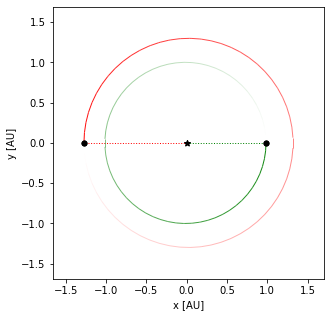

In [461]:
'''Conditions before collision'''
sim = setupSimulation()
tmax = 5e3
system_mass1 = np.array([i.m for i in sim.particles])
period1 = np.array([i.P for i in sim.calculate_orbits()])
omega1 = np.array([i.omega for i in sim.calculate_orbits()])
p1 = period1[0]
p2 = period1[1]
w1 = omega1[0]
w2 = omega1[1]

print(f'{sim.N} particles in the simulation at t = {sim.t} yr')
print(f"Protoplanet 1 Semi-Major Axis: {sim.calculate_orbits()[0].a} AU")
print(f"Protoplanet 2 Semi-Major Axis: {sim.calculate_orbits()[1].a} AU")
print(f'Period of Protoplanet 1: {p1} yr')
print(f'Period of Protoplanet 2: {p2} yr')
print(f"True Anomaly of Protoplanet 1: {w1} radians")
print(f"True Anomaly of Protoplanet 2: {w2} radians")

fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)

In [462]:
def close_encounter(sim_pointer, collision):
    global count
    sim = sim_pointer.contents
    #print(sim.t)
    #print(sim.particles[collision.p1].x)
    #print(sim.particles[collision.p2].x)
    count += 1
    return 0

Number of Close Encounters: 798 after 5000.0 yrs
Period of Protoplanet 1: 2.287420496291017 yr
Period of Protoplanet 2: 0.7626722901384584 yr
Eccentricity of Protoplanet 1: 0.25611093757423253
Eccentricity of Protoplanet 2: 0.3222221138858787


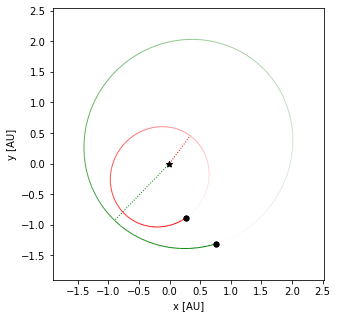

In [463]:
sim = setupSimulation()
count = 0
sim.collision = "direct"
sim.collision_resolve = close_encounter
sim.integrate(tmax)
print(f"Number of Close Encounters: {count} after {sim.t} yrs")

system_mass2 = np.array([i.m for i in sim.particles])
period2 = np.array([i.P for i in sim.calculate_orbits()])
eccentricity = np.array([i.e for i in sim.calculate_orbits()])

print(f'Period of Protoplanet 1: {period2[0]} yr')
print(f'Period of Protoplanet 2: {period2[1]} yr')
print(f"Eccentricity of Protoplanet 1: {eccentricity[0]}")
print(f"Eccentricity of Protoplanet 2: {eccentricity[1]}")

fig = rebound.OrbitPlot(sim, unitlabel='[AU]', color=['green', 'red'], periastron=True)

In [464]:
sim = setupSimulation()
times = np.linspace(0., tmax, 1000)
ecc1 = np.array([])
ecc2 = np.array([])
x1 = np.array([])
x2 = np.array([])
s1 = np.array([])
s2 = np.array([])
for i in range(len(times)):
    sim.integrate(times[i])
    temp = np.array([i.e for i in sim.calculate_orbits()])
    temp2 = np.array([i.x for i in sim.particles])
    temp3 = np.array([i.a for i in sim.calculate_orbits()])
    ecc1 = np.append(ecc1, temp[0])
    ecc2 = np.append(ecc2, temp[1])
    x1 = np.append(x1, temp2[1])
    x2 = np.append(x2, temp2[2])
    s1 = np.append(s1, temp3[0])
    s2 = np.append(s2, temp3[1])

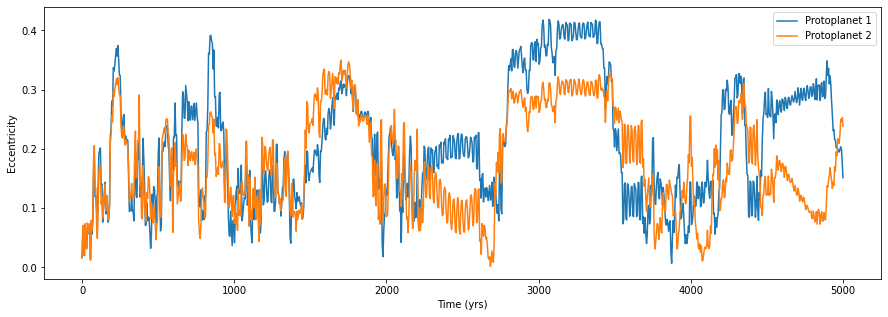

In [465]:
fig = plt.figure(figsize=(15,5))
plt.plot(times, ecc1, label= 'Protoplanet 1')
plt.plot(times,ecc2, label = 'Protoplanet 2')
plt.xlabel('Time (yrs)')
plt.ylabel('Eccentricity')
plt.legend()

Text(0.5, 1.0, 'Distance of Separation Between Protoplanet 1 and Protoplanet 2')

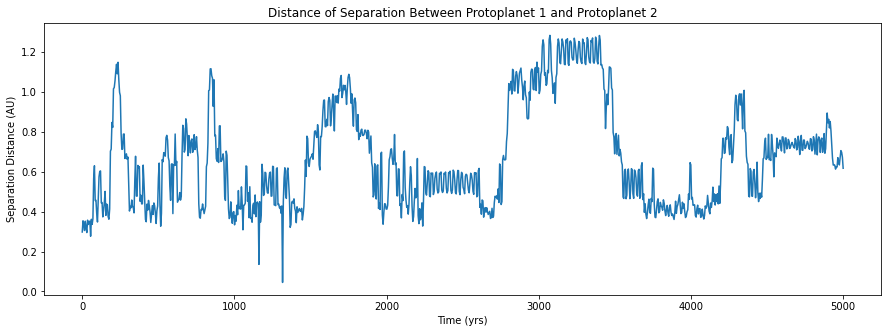

In [466]:
fig = plt.figure(figsize=(15,5))
s3 = abs(s2-s1)
plt.plot(times, s3)
plt.xlabel('Time (yrs)')
plt.ylabel('Separation Distance (AU)')
plt.title('Distance of Separation Between Protoplanet 1 and Protoplanet 2')

Text(0, 0.5, 'Power')

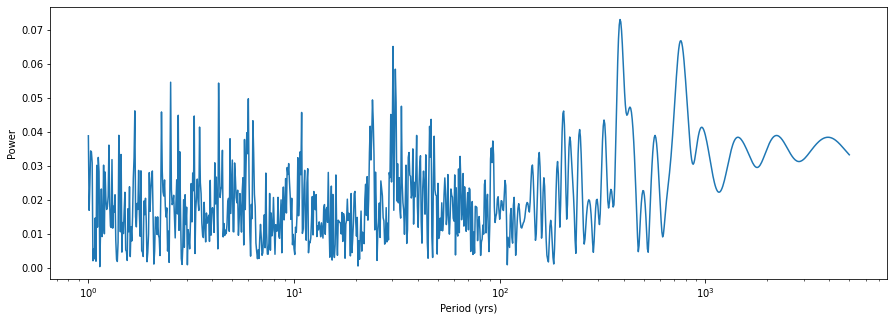

In [467]:
logPmin = np.log10(1)
logPmax = np.log10(tmax)
Ps = np.logspace(logPmin,logPmax,1000)
ws = np.asarray([2*np.pi/P for P in Ps])

periodogram = signal.lombscargle(times,x1,ws)

fig = plt.figure(figsize=(15,5))
plt.plot(Ps,np.sqrt(4*periodogram/10000))
plt.xscale('log')
plt.xlabel("Period (yrs)")
plt.ylabel("Power")

Text(0, 0.5, 'Power')

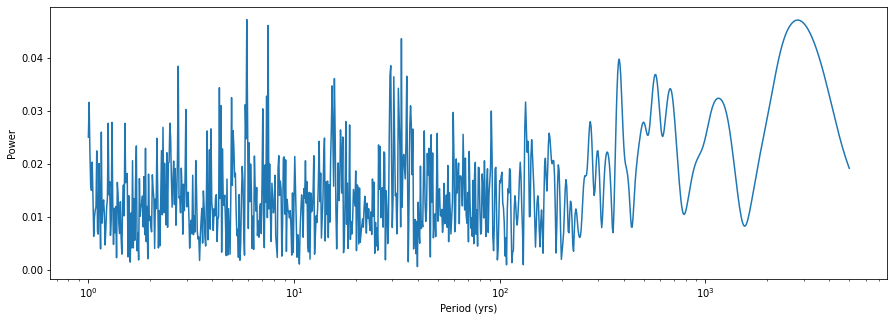

In [468]:
logPmin = np.log10(1)
logPmax = np.log10(tmax)
Ps = np.logspace(logPmin,logPmax,1000)
ws = np.asarray([2*np.pi/P for P in Ps])

periodogram = signal.lombscargle(times,x2,ws)

fig = plt.figure(figsize=(15,5))
plt.plot(Ps,np.sqrt(4*periodogram/10000))
plt.xscale('log')
plt.xlabel("Period (yrs)")
plt.ylabel("Power")